
각 시장별 업종 점유율을 시각화하여 현재 주목받고 있는 업종을 파악. (KOSPI, KOSDAQ 업종 나누는 방법 필요)

업종 나누기 : 네이버증권 업종탭에서, 각 업종별 목록을 받아옴

* 있는건 코스닥, * 없는건 코스피

데이터 전처리 : fdr.StockListing에 'Sector' 열 추가

Sector를 기반으로 groupby 하면 KOSPI, KOSDAQ 시장에서 업종별 점유율을 시각화 할 수 있음 

네이버 증권 업종 탭에서 업종 목록을 request, bs4, 안될시 selenium으로 받아옴

업종링크를 돌면서 종목명에 *이 있는것과 없는것으로 분류 -> 정규표현식 etc 등의 방법

fdr.StockListing 전처리 - kospi, kosdaq에 sector열을 추가 -> 위에서 구분한걸 기준으로 넣음

이를 기반으로 sector별 종목수를 계산 (value_counts())

이를 시각화

In [1]:
# 데이터 분석을 위한 패키지
import numpy as np
import pandas as pd

In [2]:
# 시각화 패키지
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [3]:
import FinanceDataReader as fdr

In [4]:
import koreanize_matplotlib

In [5]:
import datetime
from dateutil.relativedelta import relativedelta

In [7]:
from data_loader import load_sector_data, get_market_color

In [8]:
# 모든 컬럼,행을 출력하도록 설정
pd.set_option('display.max_columns', None) # None으로 설정하면 모든 컬럼 출력
pd.set_option('display.max_rows', None) #None으로 설정하면 모든 행 출력

In [9]:
# 업종별 점유율을 시각화 하는 함수

def visualize_sector_share(market=None, month_ago=3):
  
    df = load_sector_data(market, month_ago=month_ago)
  
    # 업종별 카운트 계산
    df_sector_cnt = df['Sector'].value_counts().sort_values(ascending=True)
    
    # 시장의 총 종목 수 계산
    total_count = len(df)  # 전체 종목 수
    
    # 업종별 비율 계산
    sector_ratio = df_sector_cnt / total_count * 100
    
    # Figure의 세로 사이즈 조정 (업종수에 따라)
    figure_height = 400 + (len(df_sector_cnt) * 30)  
    
    # 시장별 그래프 색상 설정
    color = get_market_color(market)
    
    # Plotly로 그래프 작성
    fig = px.bar(
        x=sector_ratio,
        y=df_sector_cnt.index,
        color_discrete_sequence=[color],
        title=f'{market} 시장 업종별 점유율',
        labels={'x':'점유율 (%)','y':'업종명'},
        height=figure_height
    )  
    fig.show()
    
    display(pd.DataFrame(df['Sector'].value_counts().sort_values(ascending=False)))
    

In [10]:
# 업종별 수익률 평균을 계산하고 시각화하는 함수

# 아래 개선된 함수를 사용하세요.

# def avg_return_by_sector(market=None) :
  
#   df = load_sector_data(market)
  
#   mean_return_by_sector = df.groupby('Sector').agg({'TotalReturn':'mean'}).sort_values(by='TotalReturn',ascending=True)
  
#   plt.figure(figsize=(8,20))
#   plt.barh(mean_return_by_sector.index, mean_return_by_sector['TotalReturn'], color='violet')
#   plt.title(f'{market} 업종별 수익률 평균', fontsize=16)
#   plt.show()
  
#   return mean_return_by_sector

업종별 수익률 => 색상으로 위험도를 구분 -> 위험도 순으로 정렬 -> 이를 통해 위험도 대비 수익률

In [10]:
# 업종별 수익률 평균을 계산하고 시각화하는 함수

# plotly를 사용해 사용자에게 좀 더 유용한 정보를 제공

def avg_return_by_sector(market=None, month_ago=3, risk=None):
    
    df = load_sector_data(market, month_ago=month_ago)  # 데이터 로드
    
    # 시장의 평균 수익률 계산
    market_avg_return = df['TotalReturn'].mean()
    
    # 업종별 평균 수익률, 평균 위험도도 계산
    mean_return_by_sector = df.groupby('Sector').agg({'TotalReturn': 'mean', 'Risk':'mean'}).reset_index().sort_values(by='Risk', ascending=True)
    
    # 위험도 필터링
    if risk is not None:
        mean_return_by_sector = mean_return_by_sector[mean_return_by_sector['Risk'] <= risk].sort_values(by='TotalReturn')
    
    # 시장별 그래프 색상 설정
    color = get_market_color(market)

    # Figure의 세로 사이즈 조정 (업종수에 따라)
    figure_height = 400 + (len(mean_return_by_sector) * 30)        
    
    # Plotly로 그래프 작성
    fig = px.bar(
        data_frame=mean_return_by_sector,
        x='TotalReturn', 
        y='Sector',
        color='Risk',  # 위험도를 색상으로 사용
        color_continuous_scale=px.colors.sequential.Reds,  # 색상 스케일 설정
        title=f'{market} 업종별 {month_ago}개월 평균 수익률',
        labels={'x':'평균 수익률 (%)','y':'업종명'},
        height=figure_height
    )
    
    # 평균 수직선 추가
    fig.add_shape(type='line', xref='x', yref='y',
                  x0=market_avg_return, y0=-0.5, x1=market_avg_return, y1=len(mean_return_by_sector)-0.5,
                  line=dict(color='blue', dash='dash'),
                  name=f'{market} 평균 수익률(%)')
    
    # 평균 라벨 추가
    fig.add_annotation(
        x=market_avg_return,
        y=len(mean_return_by_sector) - 0.5,
        text=f'{market} 평균 수익률(%) : {market_avg_return:.3f} %',
        showarrow=True,
        arrowhead=2,
        ax=0,
        ay=-40,
        font=dict(color='blue')
    )
    
    fig.show()

In [50]:
avg_return_by_sector(market='KOSPI', month_ago=1, risk=2)

1개월 간의 data를 불러옵니다.


In [50]:
avg_return_by_sector('KOSDAQ')

In [51]:
avg_return_by_sector('ETF')

In [20]:
visualize_sector_share('KOSPI')

3개월 간의 data를 불러옵니다.


,count
Sector,
화학,73
자동차부품,73
제약,62
식품,54
"섬유,의류,신발,호화품",49
건설,42
철강,37
증권,34
건축자재,31


In [18]:
visualize_sector_share('KOSDAQ')

3개월 간의 data를 불러옵니다.


,count
Sector,
반도체와반도체장비,142
창업투자,119
제약,111
IT서비스,82
전자장비와기기,78
자동차부품,75
건강관리장비와용품,74
기계,73
소프트웨어,72


In [17]:
visualize_sector_share('ETF')

3개월 간의 data를 불러옵니다.


,count
Sector,
해외주식,295
국내 업종/테마,248
채권,161
국내 시장지수,88
기타,79
국내파생,40
원자재,18


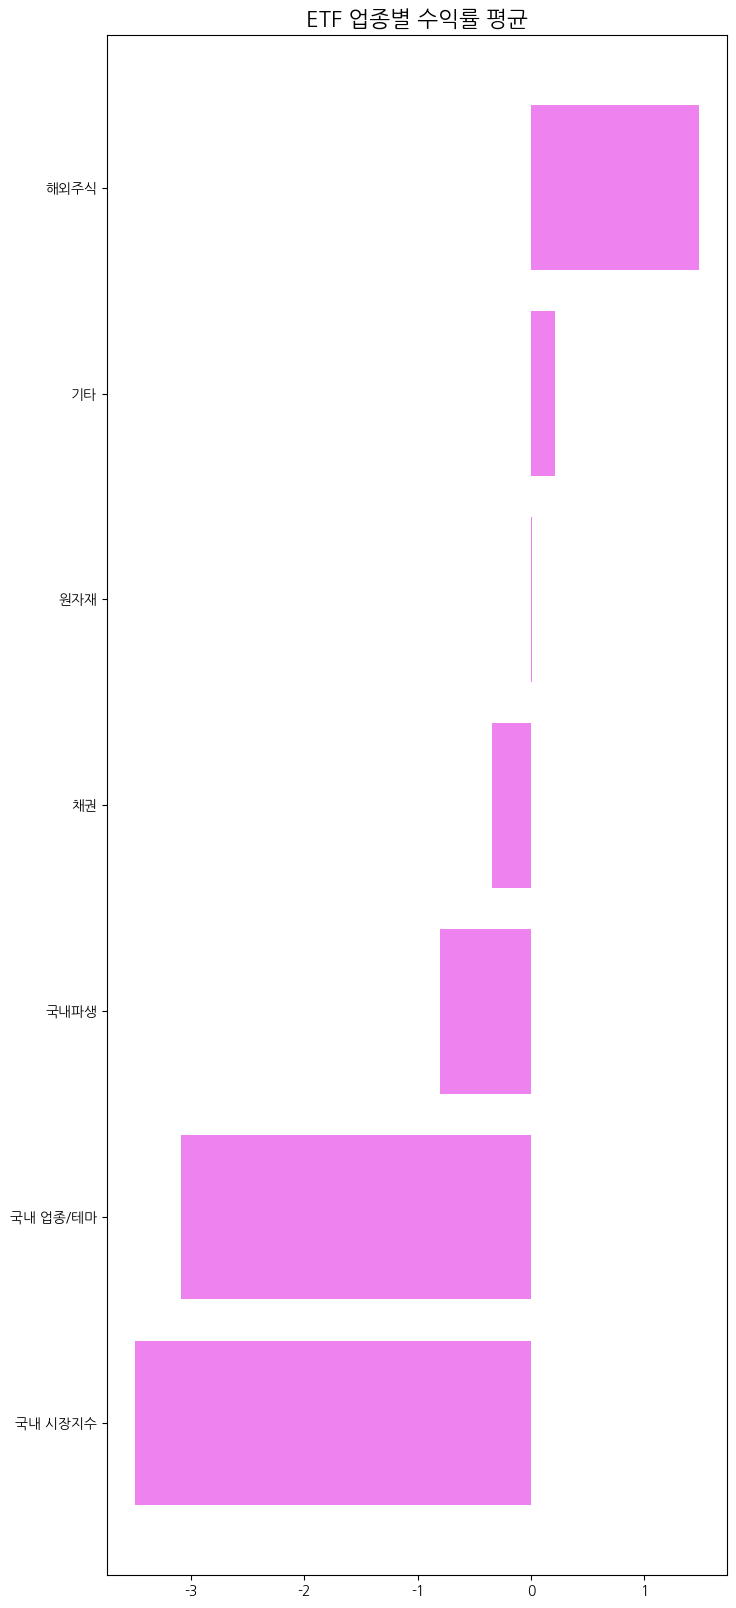

,TotalReturn
Sector,
국내 시장지수,-3.492614
국내 업종/테마,-3.090242
국내파생,-0.800000
채권,-0.341615
원자재,0.008889
기타,0.209367
해외주식,1.480475


In [12]:
avg_return_by_sector('ETF')

In [ ]:
# 업종별 수익률을 계산하기
# 업종별로 나눔 -> for문 돌려서 해당 업종만 수익률 구하기

In [ ]:
# df = pd.read_csv('sector_by_stock_list_df.csv')

In [ ]:
# 초기에는 데이터를 가공하기위해 불러옴

# kospi = fdr.StockListing('KOSPI')
# kosdaq = fdr.StockListing('KOSDAQ')
# etfs = fdr.StockListing('ETF/KR')

In [ ]:
# 전처리된 데이터 불러오기

# kospi = pd.read_csv('new_KOSPI_add_sector_df.csv')


In [ ]:
# fdr.StockListing으로 불러온 df - KOSPI와 KOSDAQ에 'Sector' 열 추가 (초기값 None)
# 처음 데이터를 가공할때 사용
# sector_analysis(데이터 전처리)에 과정이 통합되어 있습니다.

for index in range(len(df)):
    stock_name = df['종목명'][index]
    sector_name = df['업종명'][index]
    market = df['코스닥 여부'][index]
    
    if market:  # KOSDAQ인 경우
        if stock_name in kosdaq['Name'].values:
            kosdaq.loc[kosdaq['Name'] == stock_name, 'Sector'] = sector_name
    else:  # KOSPI인 경우
        if stock_name in kospi['Name'].values:
            kospi.loc[kospi['Name'] == stock_name, 'Sector'] = sector_name

# 오늘 날짜
today = datetime.datetime.today()
today = today.strftime('%Y-%m-%d')

# CSV 파일로 저장
kospi.to_csv(f'kospi_add_sector_{today}.csv', index=False, encoding='utf-8-sig')
kosdaq.to_csv(f'kosdaq_add_sector_{today}.csv', index=False, encoding='utf-8-sig')

In [17]:
# 날짜는 파이썬 표준라이브러리 datetime 사용
import datetime

# 오늘 날짜 구하기
today = datetime.datetime.today()
today_str = today.strftime('%Y-%m-%d')


# n개월 전 날짜 계산 함수(개월단위)
def calculate_start_date(months_ago, end_date):
    start_date = datetime.datetime.strptime(end_date, '%Y-%m-%d') - relativedelta(months=months_ago)
    return start_date.strftime('%Y-%m-%d')
  

# 시장과 기간을 입력받아, 모든 종목을 돌면서 수익률을 반환해주는 함수

def return_by_stock(market='KOSPI',  month_ago = 1, end_date=today_str):
  
  start_date = calculate_start_date(month_ago, end_date)
  
  results = [] # 수익률 결과를 저장할 리스트
  
  market_list= fdr.StockListing(market)
  
  try:
    
    for stock in market_list['Code'].tolist():
      data = fdr.DataReader(stock, start=start_date, end=end_date)[['Close']]
      
      if data.empty:  # 데이터가 비어있는지 확인
        print(f"종목 {stock}의 데이터가 없습니다. 건너뜁니다.")
        continue
      
      # 일일 수익률
      data['return'] = data.pct_change()
      
      # NaN 값 처리: 첫 번째 행 삭제
      data = data.dropna()
      
      # 수익률을 퍼센트로 변환
      data['return'] = data['return'] * 100
      
      # 499790, 177900, 487360 코드에서 오류발생
      # 데이터를 가져오는 중 오류가 발생했습니다: single positional indexer is out-of-bounds : 특정 인덱스에 접근할 때 그 인덱스가 존재하지 않는 경우
      # 상장된지 얼마 되지않아, 단 '하루'의 데이터만 존재하는경우, pct_change()를 호출하면 맨처음 NaN이 반환되고, dropna()를 호출하면 데이터프레임이 비게 됩니다.
      # 따라서 data가 비어있게 되어, 이후의 수익률 계산에서 single positional indexer is out-of-bounds 오류가 발생합니다. 이는 인덱스 접근을 시도할 때 데이터가 없기 때문에 발생합니다.
      
      if len(data) == 1:  # 상장이후 일일수익률 데이터가 단 하나라  수익률 계산이 의미가 없는경우
        print(f"종목 {stock}은 일일수익률 데이터가 하나라, 수익률 계산이 의미가 없기때문에 건너뜁니다.")
        continue
      
      if len(data) == 0: # 상장이후 종가가 하나라 수익률 계산 자체가 되지 않는경우
          print(f"종목 {stock}의 데이터가 충분하지 않습니다. 건너뜁니다.")
          continue
        
      # 해당 기간 전체 수익률 계산
      total_return = (data['Close'].iloc[-1] - data['Close'].iloc[0]) / data['Close'].iloc[0] * 100

      # 통계 정보 추가
      average_return = data['return'].mean()
      std_dev_return = data['return'].std()
      
      # 결과 저장
      results.append({
          'Code': stock,
          'TotalReturn': total_return,
          'AvgReturn': average_return,
          'Std': std_dev_return
      })

      # # 결과 출력
      # print(f"종목: {stock}, {month_ago}개월 총 수익률: {total_return:.2f}%, 평균 수익률: {average_return:.2f}%, 표준편차: {std_dev_return:.4f}")
   
    return pd.DataFrame(results)
  except Exception as e:
    print(f"데이터를 가져오는 중 오류가 발생했습니다: {e}")
    return None


In [21]:
# KOSPI 종목들의 수익률

kospi_df = return_by_stock(market='KOSPI', month_ago=1)

kospi_df.head()

,종목,총 수익률,평균 수익률,표준편차
0,005930,-0.922509,-0.152225,1.620596
1,000660,9.130707,0.425609,2.300046
2,373220,-8.781127,-0.690052,2.717703
3,207940,-4.205128,-0.331636,1.389048
4,005380,-1.601831,-0.071277,2.109992


In [18]:
# 전처리가 끝난 데이터 불러오기

kospi_df = pd.read_csv('new_KOSPI_df.csv')
kospi_df.head()

,Code,Name,Volatility,TotalReturn,AvgReturn
0,005930,삼성전자,1.578523,0.186567,-0.036956
1,000660,SK하이닉스,2.346059,9.886650,0.487213
2,373220,LG에너지솔루션,2.568578,-11.111111,-0.451771
3,207940,삼성바이오로직스,1.327286,-3.810505,-0.217512
4,005380,현대차,2.167478,-0.462963,-0.063012


In [31]:
kosdaq_df = pd.read_csv('new_KOSDAQ_df.csv')
kosdaq_df.head()

,Code,Name,Volatility,TotalReturn,AvgReturn
0,196170,알테오젠,4.780943,-0.331126,0.486394
1,247540,에코프로비엠,2.686852,-21.454545,-1.140209
2,028300,HLB,2.654853,-1.540616,-0.077903
3,086520,에코프로,2.214570,-24.603175,-1.485840
4,141080,리가켐바이오,4.850454,5.924413,0.543159


In [2]:
# 종목별 수익률과 편차를 구한 DataFrame에 파생열 'Sector', 'Name' 추가
# 현재 이 함수는 잘 작동하나, 구조가 다소 비효율적으로 보임 
# 성능개선을 위한 구조변경이 필요
# kospi의 Code와 kospi_df의 종목을 기준으로 merge를 해보면 좀더 괜찮을지도?
# deprecated : 아래 개선된 함수를 사용하세요.

# def add_sector_info(market=str) :
#   if market == 'KOSPI' :
#     kospi_df = return_by_stock(market=market, month_ago=1)
#     kospi_df['Sector'] = None
#     kospi_df['Name'] = None
  
#     for index in range(len(kospi)) : 
#       code = kospi['Code'][index]
#       sector = kospi['Sector'][index]
#       name = kospi['Name'][index]
      
#       if code in kospi_df['Code'].values :
#         kospi_df.loc[kospi_df['Code'] == code, 'Sector'] = sector
#         kospi_df.loc[kospi_df['Code'] == code, 'Name'] = name
        
#     return kospi_df          
  
#   if market == 'KOSDAQ' : 
#     kosdaq_df = return_by_stock(market=market, month_ago=1)
#     kosdaq_df['Sector'] = None
#     kosdaq_df['Name'] = None

#     for index in range(len(kosdaq)) : 
#       code = kosdaq['Code'][index]
#       sector = kosdaq['Sector'][index]
#       name = kosdaq['Name'][index]
      
#       if code in kosdaq_df['Code'].values :
#         kosdaq_df.loc[kosdaq_df['Code'] == code, 'Sector'] = sector
#         kosdaq_df.loc[kosdaq_df['Code'] == code, 'Name'] = name   
        
#     return kosdaq_df  
  

In [37]:
# 개선된 함수 - 데이터 전처리

# 반복문의 사용을 줄이고, 중복 코드를 줄인 형태

# merge를 통해 두 df를 결합하였기 때문에, 대량의 데이터 소화시 성능향상이 기대

def add_sector_info(*, market=None, local_df=None, local_market=None) :
    
    if local_df is None and market is None:
        raise ValueError("market 또는 local_df중 하나는 반드시 제공되어야 합니다.")
    # 종목 데이터 가져오기
    elif local_df is not None :
        df = local_df  
    elif market in ['KOSPI','KOSDAQ'] :
        df = return_by_stock(market=market, month_ago=1)
    else:
        raise ValueError(" 'KOSPI', 'KOSDAQ' 두 시장만 지원하는 기능입니다.")  
        
    # KOSPI 또는 KOSDAQ 데이터프레임 선택
    if local_market is not None:
        sector_data = kospi if local_market.lower() == 'kospi' else kosdaq if local_market.lower() == 'kosdaq' else None
        if sector_data is None:
            raise ValueError("local_market은 'KOSPI' 또는 'KOSDAQ'이어야 합니다.")
    elif market == 'KOSPI':
        sector_data = kospi
    elif market == 'KOSDAQ':
        sector_data = kosdaq

        
    # 'Code'를 인덱스로 설정
    sector_data = sector_data.set_index('Code')

    # 업종과 시가총액, 거래량, 거래대금 추가
    # 이 데이터는 현재 날짜 기준
    df = df.merge(sector_data[['Sector','Volume','Amount','Marcap']], left_on='Code', right_index=True, how='left')

    return df

In [ ]:
avg_return_by_sector('KOSDAQ')

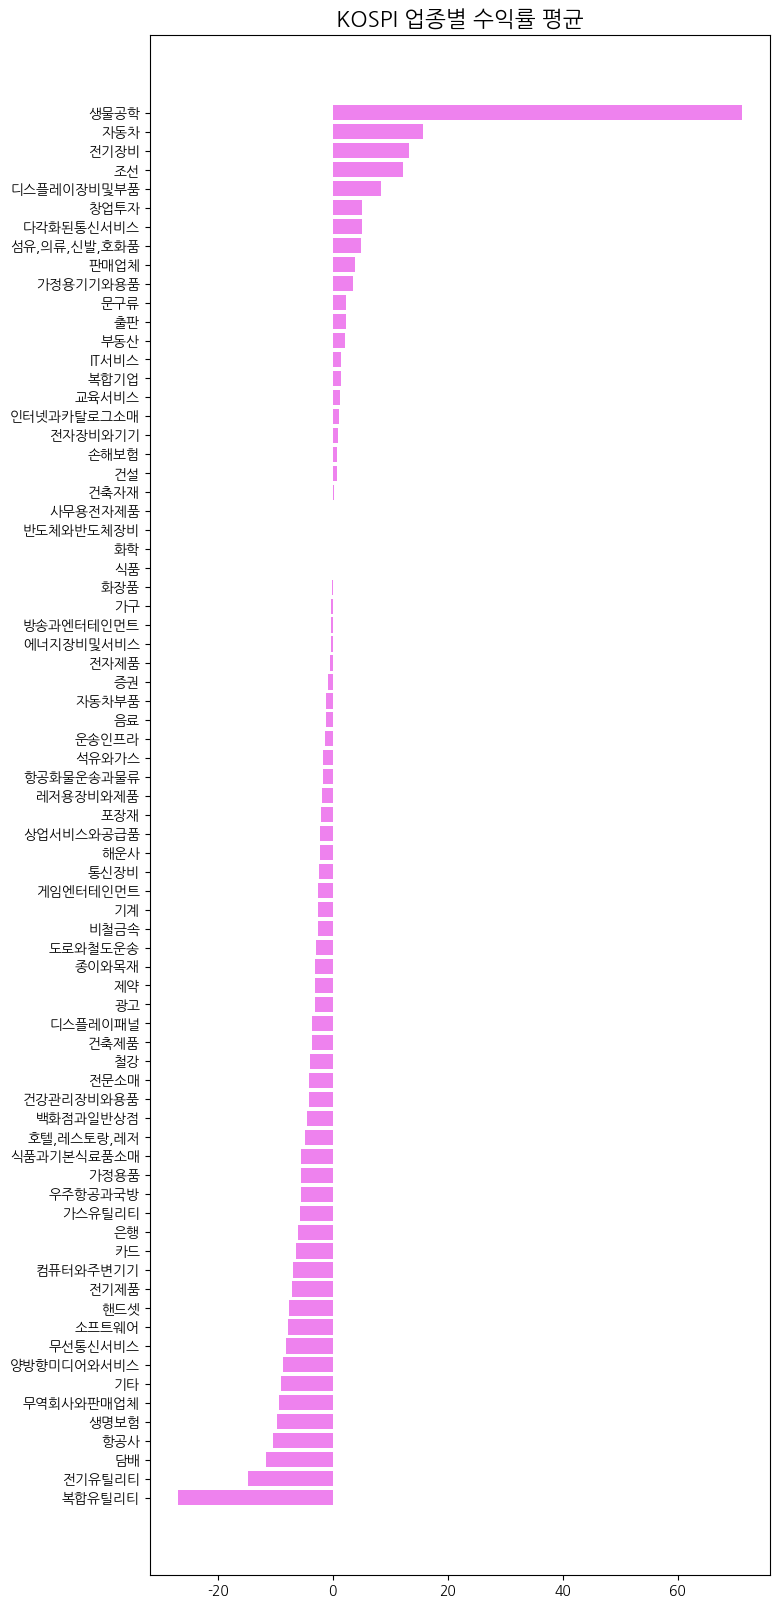

In [53]:
# KOSPI 업종별 1개월 수익률 평균 시각화
# 0을 기준으로 +인 부분과 -인부분의 색을 다르게 하면 좋을거 같음 

plt.figure(figsize=(8,20))
plt.barh(kospi_sector_return_mean.index, kospi_sector_return_mean['TotalReturn'], color='violet')
plt.title('KOSPI 업종별 수익률 평균', fontsize=16)
plt.show()

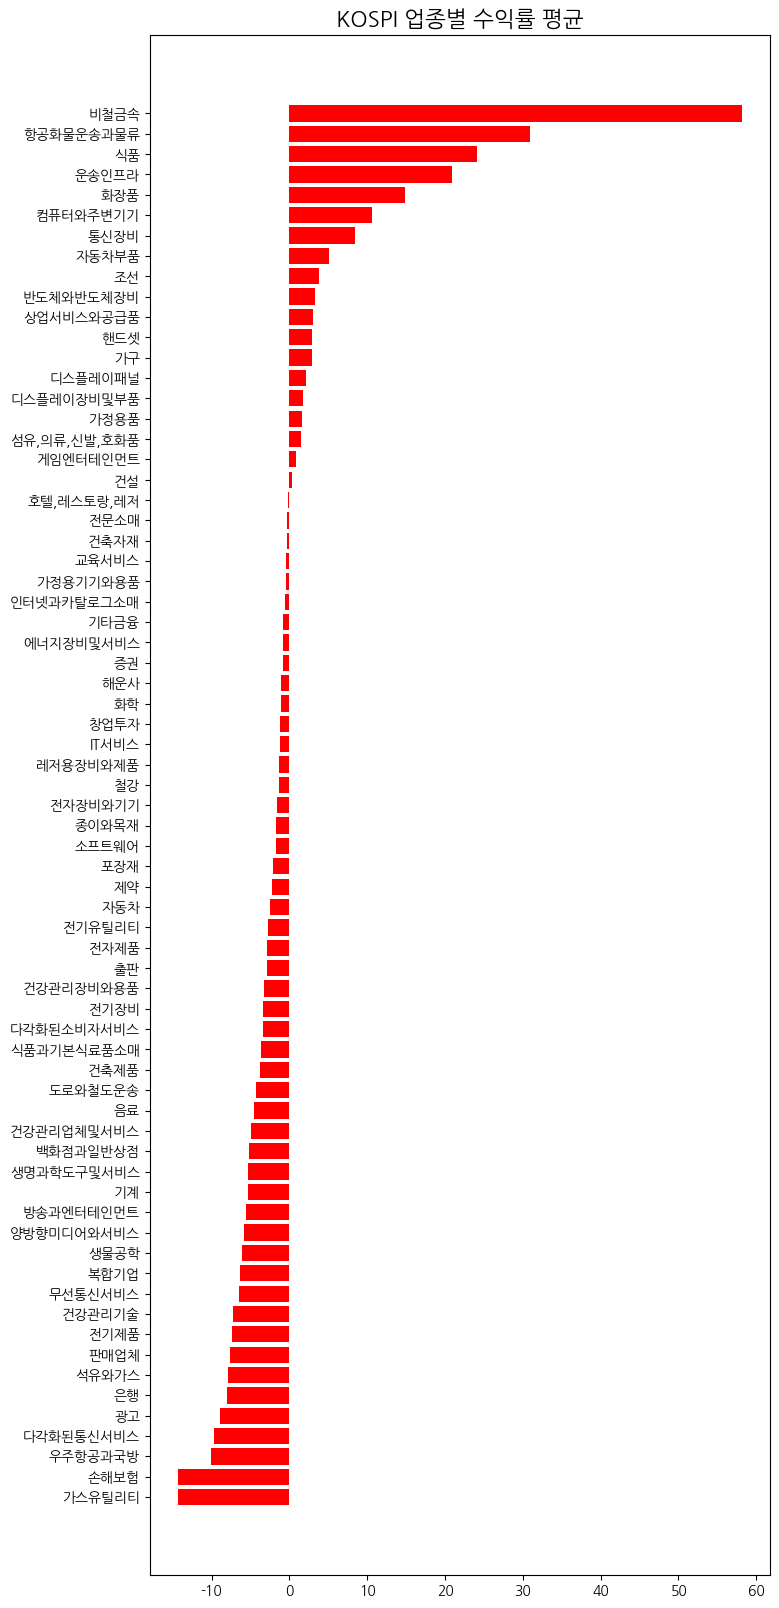

In [57]:
# KOSDAQ 업종별 1개월 수익률 평균 시각화
# 0을 기준으로 +인 부분과 -인부분의 색을 다르게 하면 좋을거 같음 

plt.figure(figsize=(8,20))
plt.barh(kosdaq_sector_return_mean.index, kosdaq_sector_return_mean['TotalReturn'], color='red')
plt.title('KOSPI 업종별 수익률 평균', fontsize=16)
plt.show()

In [9]:
tmp = load_sector_data('KOSPI', month_ago=3)

tmp['Volatility'].max()

3개월 간의 data를 불러옵니다.


11.77

In [12]:
tmp.describe()

,Volatility,TotalReturn,AvgReturn,Volume,Amount,Marcap
count,961.000000,961.000000,961.000000,9.610000e+02,9.610000e+02,9.610000e+02
mean,2.668033,-4.005130,-0.066073,4.240753e+05,8.564069e+09,2.079216e+12
std,1.641230,23.352213,0.363349,2.612789e+06,4.635723e+10,1.249500e+13
min,0.000000,-90.600000,-2.239843,0.000000e+00,0.000000e+00,2.598216e+09
25%,1.640000,-13.630000,-0.227544,1.120200e+04,9.631254e+07,7.721987e+10
50%,2.310000,-6.580000,-0.090633,5.555000e+04,3.923429e+08,1.961254e+11
75%,3.260000,0.670000,0.039373,2.145840e+05,2.470671e+09,7.200931e+11
max,11.770000,290.220000,2.844218,6.669256e+07,1.047542e+12,3.247562e+14


In [10]:
tmp['Volatility'].min()

0.0

In [30]:
tmp['Volatility'].values

array([ 2.27,  2.92,  3.08,  1.98,  2.08,  2.15,  2.17,  2.2 ,  2.74,
        2.07,  3.83,  2.42,  2.07,  2.79,  2.17,  1.67,  9.45,  2.59,
        3.29,  2.8 ,  3.21,  2.83,  2.93,  3.88,  2.22,  2.25,  2.59,
        2.81,  3.45,  1.87,  3.11,  2.13,  1.37,  3.21,  1.66,  4.71,
        1.31,  3.52,  3.71,  1.75,  2.22,  2.32,  2.63,  2.72,  2.14,
        1.94,  3.1 ,  2.35,  3.93,  1.79,  2.98,  2.56,  3.28,  2.59,
        3.45,  2.11,  2.  ,  2.62,  3.98,  3.37,  1.69,  3.4 ,  2.71,
        3.89,  3.08,  0.97,  2.61,  2.25,  2.3 ,  2.06,  4.28,  2.68,
        4.31,  2.  ,  1.44,  2.82,  4.7 ,  1.58,  1.55,  4.41,  2.88,
        4.81,  3.35,  1.73,  2.05,  3.47,  3.98,  2.07,  2.61,  2.28,
        1.49,  4.79,  1.3 ,  3.1 ,  3.19,  3.98,  1.63,  2.17,  2.23,
        3.99,  3.35,  3.61,  3.36,  2.29,  4.12,  2.75,  1.86,  2.83,
        2.89,  6.1 ,  3.96,  3.3 ,  1.77,  2.43,  3.35,  1.91,  2.55,
        1.75,  3.07,  1.85,  2.44,  2.36,  2.05,  4.63,  3.1 ,  5.21,
        2.28,  3.94,

In [27]:
quantile = tmp['Volatility'].quantile([0.25, 0.5, 0.75])


type(quantile[0.25])

numpy.float64

In [ ]:
tmp2 = load_sector_data('KOSPI', month_ago=3)

In [16]:
tmp.select_dtypes(np.number).corr()



,Volatility,TotalReturn,AvgReturn,Volume,Amount,Marcap
Volatility,1.000000,0.359845,0.382867,0.328090,0.113148,-0.001114
TotalReturn,0.359845,1.000000,0.938610,0.475092,0.084901,0.004212
AvgReturn,0.382867,0.938610,1.000000,0.358464,0.075920,0.006217
Volume,0.328090,0.475092,0.358464,1.000000,0.350239,0.218321
Amount,0.113148,0.084901,0.075920,0.350239,1.000000,0.888959
Marcap,-0.001114,0.004212,0.006217,0.218321,0.888959,1.000000
